In [134]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# pip install transliterate 
!pip install transliterate

/kaggle/input/bank-credit-risk-assessment/bank_credit_scoring.csv
/kaggle/input/bank-credit-risk-assessment/bank_credit_scoring.xlsx


In [135]:
import matplotlib.pyplot as plt
import seaborn as sns

from transliterate import translit
from sklearn.preprocessing import StandardScaler
from category_encoders import TargetEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings('ignore')

In [136]:
# Load the data and view first 5 entries
df = pd.read_csv('/kaggle/input/bank-credit-risk-assessment/bank_credit_scoring.csv')
df.head()

,Задолженность,"Просрочка, дни",Первоначльный лимит,BIRTHDATE,SEX,EDU,INCOME,TERM,Рейтинг кредитной истории,LV_AREA,LV_SETTLEMENTNAME,INDUSTRYNAME,PDN,CLIENTID,SCORINGMARK,UNDERAGECHILDRENCOUNT,VELCOMSCORING,FAMILYSTATUS
0,6063.50,3,7000.0,1983-07-08,Мужской,Среднее специальное,703.07,60,A1,Гомельская область,КОСАКОВКА,АПК,0.98,919517,233.0,0,NaN,1
1,3765.04,0,5000.0,1987-12-19,Женский,Высшее,1693.68,60,B2,NaN,МИНСК,Финансы и страхование,0.17,539353,NaN,1,NaN,1
2,2067.66,0,2650.0,1966-02-28,Женский,Среднее,724.49,60,C2,ГРОДНЕНСКАЯ,ЁДКИ,Медицина и здравоохранение,0.40,818913,NaN,0,NaN,2
3,2370.39,0,3000.0,1972-02-18,Женский,Среднее специальное,1045.84,60,A3,МИНСКАЯ,ФАНИПОЛЬ,Государственное управление,0.29,691598,216.0,0,NaN,2
4,2280.55,0,3000.0,1997-02-23,Женский,Высшее,1092.65,60,B3,NaN,Минск,Медицина и здравоохранение,0.63,425193,NaN,0,NaN,2


## 1. Data Exploration and Cleaning

We need to rename the columns and translate some attributes from Russian to English.

In [137]:
# Looks like we need to rename columns
new_columns = [
    'Debt', 'Overdue Days', 'Initial Limit', 'Birth Date', 'Sex', 'Education', 
    'Income', 'Loan Term', 'Credit History Rating', 'Living Area', 
    'Settlement Name', 'Industry Name', 'Probability of Default', 'Client ID', 
    'Scoring Mark', 'Underage Children Count', 'Velcom Scoring', 'Family Status'
]

# Check if the number of new names matches the number of columns
if len(new_columns) == len(df.columns):
    df.columns = new_columns
else:
    print(f"Error: The DataFrame has {len(df.columns)} columns, but {len(new_columns)} names were provided.")

In [138]:
# Check the new df
df.head()

,Debt,Overdue Days,Initial Limit,Birth Date,Sex,Education,Income,Loan Term,Credit History Rating,Living Area,Settlement Name,Industry Name,Probability of Default,Client ID,Scoring Mark,Underage Children Count,Velcom Scoring,Family Status
0,6063.50,3,7000.0,1983-07-08,Мужской,Среднее специальное,703.07,60,A1,Гомельская область,КОСАКОВКА,АПК,0.98,919517,233.0,0,NaN,1
1,3765.04,0,5000.0,1987-12-19,Женский,Высшее,1693.68,60,B2,NaN,МИНСК,Финансы и страхование,0.17,539353,NaN,1,NaN,1
2,2067.66,0,2650.0,1966-02-28,Женский,Среднее,724.49,60,C2,ГРОДНЕНСКАЯ,ЁДКИ,Медицина и здравоохранение,0.40,818913,NaN,0,NaN,2
3,2370.39,0,3000.0,1972-02-18,Женский,Среднее специальное,1045.84,60,A3,МИНСКАЯ,ФАНИПОЛЬ,Государственное управление,0.29,691598,216.0,0,NaN,2
4,2280.55,0,3000.0,1997-02-23,Женский,Высшее,1092.65,60,B3,NaN,Минск,Медицина и здравоохранение,0.63,425193,NaN,0,NaN,2


In [139]:
# See unique values in columns with object dtype
cols = df.select_dtypes(include='object').columns
for col in cols:
    print(col, '-', df[col].unique())

Birth Date - ['1983-07-08' '1987-12-19' '1966-02-28' ... '2002-11-05' '2003-09-15'
 '1994-01-14']
Sex - ['Мужской' 'Женский']
Education - ['Среднее специальное' 'Высшее' 'Среднее' 'Неоконченное высшее'
 '**Послевузовское']
Credit History Rating - ['A1' 'B2' 'C2' 'A3' 'B3' 'C1' 'D1' nan 'D2' 'C3' 'A2' 'B1' 'D3' '-1' 'E1'
 'E3' 'E2']
Living Area - ['Гомельская область' nan 'ГРОДНЕНСКАЯ' 'МИНСКАЯ' 'БРЕСТСКАЯ' 'г. Минск'
 'ГОМЕЛЬСКАЯ' 'Минская область' 'Брестская область' 'Гродненская область'
 'Могилевская область' 'Витебская область' 'Г. МИНСК' 'ВИТЕБСКАЯ ОБЛАСТЬ'
 'ВИТЕБСКАЯ' 'Могилевская' 'МОГИЛЕВСКАЯ' 'МИНСКАЯ ОБЛАСТЬ'
 'ГОМЕЛЬСКАЯ ОБЛАСТЬ' 'МОГИЛЁВСКАЯ' 'Минская' 'БРЕСТСКАЯ ОБЛАСТЬ'
 'ГРОДНЕНСКАЯ ОБЛАСТЬ' 'МОГИЛЕВСКАЯ ОБЛАСТЬ' 'Витебская' 'Гомельская'
 'МИНСК' 'Брестская' 'Гродненская' 'ГОМЕЛЬСКАЯ ОБЛ' 'МОГИЛЕВСК']
Settlement Name - ['КОСАКОВКА' 'МИНСК' 'ЁДКИ' ... 'ДИВИН' 'Копцевичи' 'Жалы']
Industry Name - ['АПК' 'Финансы и страхование' 'Медицина и здравоохранение'
 'Государственное

In [140]:
# Translate unique values in columns with object dtypes

# Translate Sex
df['Sex'] = df['Sex'].map({'Мужской': 'Male', 'Женский': 'Female'})

In [141]:
# Translate Education
df['Education'] = df['Education'].map({
    'Среднее специальное': 'Specialized Secondary',
    'Высшее': 'Higher',
    'Среднее': 'Secondary',
    'Неоконченное высшее': 'Incomplete Higher',
    '**Послевузовское': 'Postgraduate'
})

In [142]:
# Translare Industry Type
industry_map = {
    'АПК': 'Agro-Industrial Complex',
    'Финансы и страхование': 'Finance and Insurance',
    'Медицина и здравоохранение': 'Healthcare',
    'Государственное управление': 'Government Administration',
    'Производство': 'Manufacturing',
    'Услуги населению': 'Public Services',
    'Строительство': 'Construction',
    'Торговля': 'Trade',
    'Информационные технологии': 'Information Technology',
    'Транспорт/перевозки': 'Transport/Logistics',
    'Иное': 'Other',
    'Наука и образование': 'Science and Education',
    'Спорт и туризм': 'Sports and Tourism',
    'МВД/МЧС/МО': 'Law Enforcement/Emergency/Military',
    'Культура и искусство': 'Culture and Arts',
    'Пенсионер': 'Pensioner'
}

df['Industry Name'] = df['Industry Name'].map(industry_map)

In [143]:
# Translate Living Area
living_area_map = {
    # Gomel Region
    'Гомельская область': 'Gomel Region',
    'ГОМЕЛЬСКАЯ': 'Gomel Region',
    'ГОМЕЛЬСКАЯ ОБЛАСТЬ': 'Gomel Region',
    'Гомельская': 'Gomel Region',
    'ГОМЕЛЬСКАЯ ОБЛ': 'Gomel Region',

    # Grodno Region
    'ГРОДНЕНСКАЯ': 'Grodno Region',
    'Гродненская область': 'Grodno Region',
    'Гродненская': 'Grodno Region',
    'ГРОДНЕНСКАЯ ОБЛАСТЬ': 'Grodno Region',

    # Minsk Region
    'МИНСКАЯ': 'Minsk Region',
    'Минская область': 'Minsk Region',
    'Минская': 'Minsk Region',
    'МИНСКАЯ ОБЛАСТЬ': 'Minsk Region',

    # Brest Region
    'БРЕСТСКАЯ': 'Brest Region',
    'Брестская область': 'Brest Region',
    'Брестская': 'Brest Region',
    'БРЕСТСКАЯ ОБЛАСТЬ': 'Brest Region',

    # Mogilev Region
    'Могилевская область': 'Mogilev Region',
    'МОГИЛЕВСКАЯ': 'Mogilev Region',
    'МОГИЛЕВСКАЯ ОБЛАСТЬ': 'Mogilev Region',
    'МОГИЛЁВСКАЯ': 'Mogilev Region',
    'Могилевская': 'Mogilev Region',
    'МОГИЛЕВСК': 'Mogilev Region',

    # Vitebsk Region
    'Витебская область': 'Vitebsk Region',
    'ВИТЕБСКАЯ ОБЛАСТЬ': 'Vitebsk Region',
    'ВИТЕБСКАЯ': 'Vitebsk Region',
    'Витебская': 'Vitebsk Region',

    # Minsk City
    'г. Минск': 'Minsk City',
    'Г. МИНСК': 'Minsk City',
    'МИНСК': 'Minsk City'
}

df['Living Area'] = df['Living Area'].map(living_area_map)

In [144]:
# Standardize Settlement Name 
# Convert to lowercase and transliterate Russian text to Latin
df['Settlement Name'] = df['Settlement Name'].str.lower()
df['Settlement Name'] = df['Settlement Name'].apply(
    lambda x: translit(x, 'ru', reversed=True) if isinstance(x, str) and any(c in x for c in 'абвгдеёжзийклмнопрстуфхцчшщъыьэюя') else x
)

# Group rare settlements (<10 occurrences) into 'Other'
settlement_counts = df['Settlement Name'].value_counts()
df['Settlement Name'] = df['Settlement Name'].apply(
    lambda x: x if settlement_counts.get(x, 0) >= 10 else 'Other'
)

In [145]:
# Confirm if unique values in columns with object dtype have been translated to English
cols = df.select_dtypes(include='object').columns
for col in cols:
    print(col, '-', df[col].unique())

Birth Date - ['1983-07-08' '1987-12-19' '1966-02-28' ... '2002-11-05' '2003-09-15'
 '1994-01-14']
Sex - ['Male' 'Female']
Education - ['Specialized Secondary' 'Higher' 'Secondary' 'Incomplete Higher'
 'Postgraduate']
Credit History Rating - ['A1' 'B2' 'C2' 'A3' 'B3' 'C1' 'D1' nan 'D2' 'C3' 'A2' 'B1' 'D3' '-1' 'E1'
 'E3' 'E2']
Living Area - ['Gomel Region' nan 'Grodno Region' 'Minsk Region' 'Brest Region'
 'Minsk City' 'Mogilev Region' 'Vitebsk Region']
Settlement Name - ['Other' 'minsk' "fanipol'" 'brest' "gomel'" 'grodno' 'oshmjany'
 'svetlogorsk' 'kobrin' "krasnopol'e" 'kolodischi' "cherven'" 'rechitsa'
 'zhodino' 'kletsk' 'mogilev' 'borisov' 'proskurni' 'lesnoj'
 'verhnedvinsk' 'trilesino' 'molodechno' 'drogichin' 'polotsk'
 "mar'ina gorka" 'postavy' 'soligorsk' 'vitebsk' 'domachevo' 'bobrujsk'
 'zhlobin' 'vilejka' 'byhov' 'baranovichi' 'rudensk' 'lida' "ross'"
 'slonim' 'stolbtsy' 'krichev' "svisloch'" "zamostoch'e" "lepel'"
 "zarech'e" 'dobrush' 'dvorische' 'senno' 'nemojta' 'novo

In [146]:
# View transformed df
df.head()

,Debt,Overdue Days,Initial Limit,Birth Date,Sex,Education,Income,Loan Term,Credit History Rating,Living Area,Settlement Name,Industry Name,Probability of Default,Client ID,Scoring Mark,Underage Children Count,Velcom Scoring,Family Status
0,6063.50,3,7000.0,1983-07-08,Male,Specialized Secondary,703.07,60,A1,Gomel Region,Other,Agro-Industrial Complex,0.98,919517,233.0,0,NaN,1
1,3765.04,0,5000.0,1987-12-19,Female,Higher,1693.68,60,B2,NaN,minsk,Finance and Insurance,0.17,539353,NaN,1,NaN,1
2,2067.66,0,2650.0,1966-02-28,Female,Secondary,724.49,60,C2,Grodno Region,Other,Healthcare,0.40,818913,NaN,0,NaN,2
3,2370.39,0,3000.0,1972-02-18,Female,Specialized Secondary,1045.84,60,A3,Minsk Region,fanipol',Government Administration,0.29,691598,216.0,0,NaN,2
4,2280.55,0,3000.0,1997-02-23,Female,Higher,1092.65,60,B3,NaN,minsk,Healthcare,0.63,425193,NaN,0,NaN,2


In [147]:
# View shape
df.shape

(18420, 18)

In [148]:
# Check column basic info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18420 entries, 0 to 18419
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Debt                     18420 non-null  float64
 1   Overdue Days             18420 non-null  int64  
 2   Initial Limit            18420 non-null  float64
 3   Birth Date               18420 non-null  object 
 4   Sex                      18420 non-null  object 
 5   Education                18420 non-null  object 
 6   Income                   18420 non-null  float64
 7   Loan Term                18420 non-null  int64  
 8   Credit History Rating    17488 non-null  object 
 9   Living Area              16297 non-null  object 
 10  Settlement Name          18420 non-null  object 
 11  Industry Name            18420 non-null  object 
 12  Probability of Default   18420 non-null  float64
 13  Client ID                18420 non-null  int64  
 14  Scoring Mark          

In [149]:
# Check null values in each column
df.isnull().sum()

Debt                          0
Overdue Days                  0
Initial Limit                 0
Birth Date                    0
Sex                           0
Education                     0
Income                        0
Loan Term                     0
Credit History Rating       932
Living Area                2123
Settlement Name               0
Industry Name                 0
Probability of Default        0
Client ID                     0
Scoring Mark               1634
Underage Children Count       0
Velcom Scoring             9531
Family Status                 0
dtype: int64

In [150]:
# Check for duplicated entries
df.duplicated().sum()

2

In [151]:
# View summary statistics of numerical features
df.describe()

,Debt,Overdue Days,Initial Limit,Income,Loan Term,Probability of Default,Client ID,Scoring Mark,Underage Children Count,Velcom Scoring,Family Status
count,18420.000000,18420.000000,18420.000000,18420.000000,18420.000000,18420.000000,1.842000e+04,16786.000000,18420.000000,8889.000000,18420.000000
mean,4318.769750,9.196743,5127.834256,1664.840782,52.301737,0.290288,8.226245e+05,186.432622,0.636754,177.040162,1.498751
std,4336.432353,42.309092,4879.201691,1048.813447,13.378788,0.144359,1.966853e+05,67.430848,0.854167,310.624940,0.500988
min,0.000000,0.000000,180.000000,0.000000,23.000000,0.000000,1.289800e+04,-108.000000,0.000000,-2.000000,1.000000
25%,1287.900000,0.000000,1550.000000,1021.692500,36.000000,0.190000,7.193478e+05,134.000000,0.000000,-2.000000,1.000000
50%,2675.670000,0.000000,3200.000000,1460.175000,60.000000,0.300000,9.083645e+05,182.000000,0.000000,-2.000000,1.000000
75%,5785.870000,0.000000,6912.500000,1980.460000,60.000000,0.390000,9.621360e+05,234.000000,1.000000,278.000000,2.000000
max,40000.000000,491.000000,40000.000000,29942.820000,60.000000,1.210000,1.061453e+06,416.000000,3.000000,998.000000,4.000000


In [152]:
# Handle Duplicates
df = df.drop_duplicates()
print("Duplicates after cleaning:", df.duplicated().sum())

Duplicates after cleaning: 0


In [153]:
# Handle Missing Values
# Credit History Rating: Impute with mode
df['Credit History Rating'].fillna(df['Credit History Rating'].mode()[0], inplace=True)

# Living Area: Impute with mode
df['Living Area'].fillna(df['Living Area'].mode()[0], inplace=True)

# Settlement Name: Impute with 'Unknown'
df['Settlement Name'].fillna('Unknown', inplace=True)

# Scoring Mark: Impute with median
df['Scoring Mark'].fillna(df['Scoring Mark'].median(), inplace=True)

# Velcom Scoring: Impute with median (since it has significant missing values)
df['Velcom Scoring'].fillna(df['Velcom Scoring'].median(), inplace=True)

# Verify missing values are handled
print("\nMissing Values After Imputation:")
print(df.isnull().sum())


Missing Values After Imputation:
Debt                       0
Overdue Days               0
Initial Limit              0
Birth Date                 0
Sex                        0
Education                  0
Income                     0
Loan Term                  0
Credit History Rating      0
Living Area                0
Settlement Name            0
Industry Name              0
Probability of Default     0
Client ID                  0
Scoring Mark               0
Underage Children Count    0
Velcom Scoring             0
Family Status              0
dtype: int64


## 2. EDA

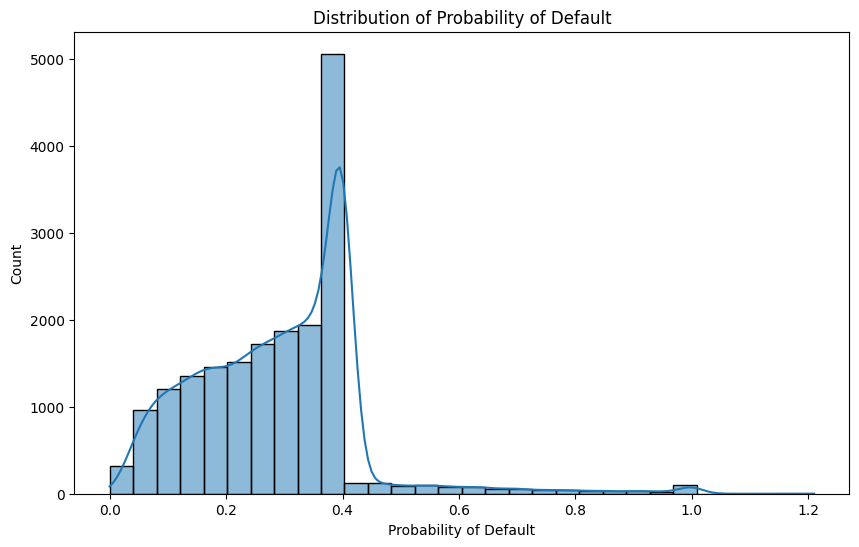

In [154]:
# Distribution of Probability of Default
plt.figure(figsize=(10, 6))
sns.histplot(df['Probability of Default'], bins=30, kde=True)
plt.title('Distribution of Probability of Default')
plt.xlabel('Probability of Default')
plt.ylabel('Count')
plt.show()

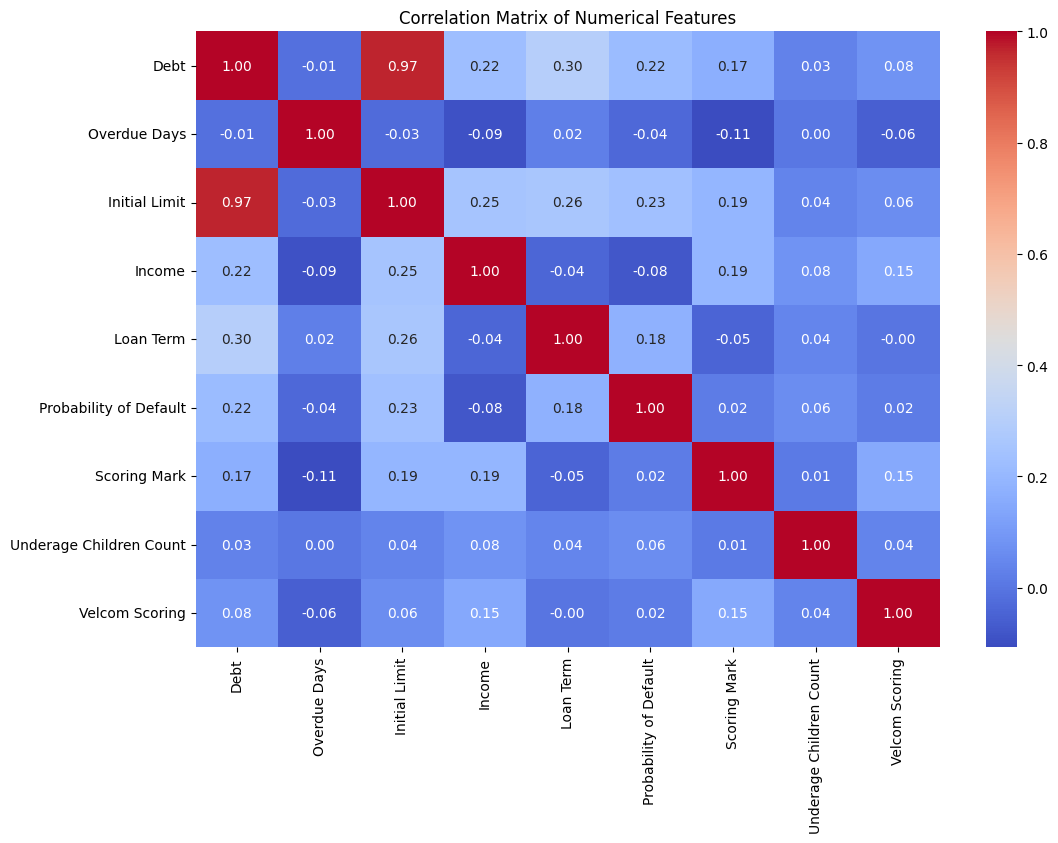

In [155]:
# Correlation Matrix
numerical_cols = ['Debt', 'Overdue Days', 'Initial Limit', 'Income', 'Loan Term', 
                 'Probability of Default', 'Scoring Mark', 'Underage Children Count', 'Velcom Scoring']
plt.figure(figsize=(12, 8))
sns.heatmap(df[numerical_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

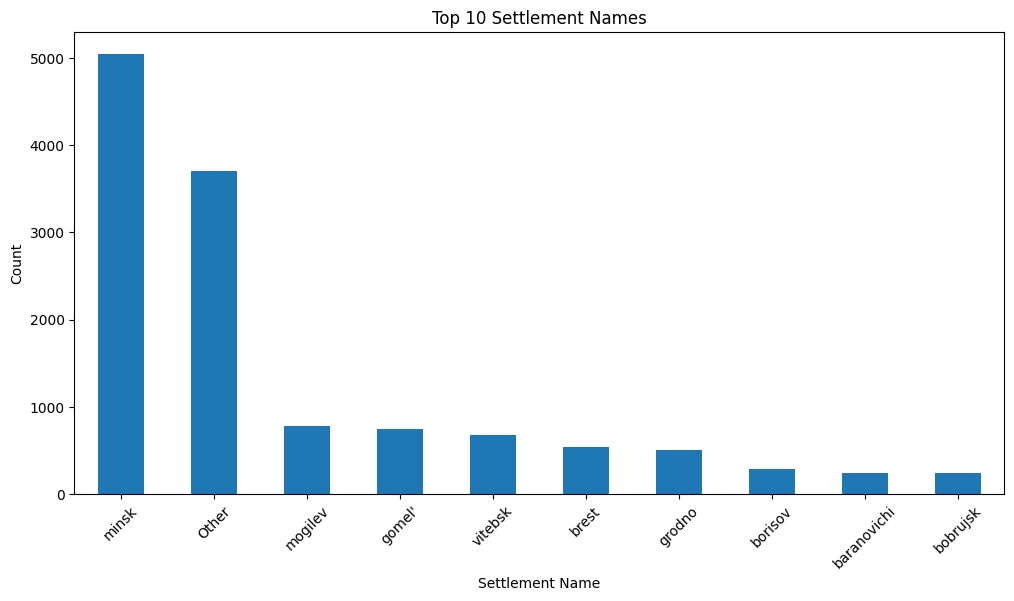

In [156]:
# Settlement Name Frequency (Top 10)
plt.figure(figsize=(12, 6))
df['Settlement Name'].value_counts().head(10).plot(kind='bar')
plt.title('Top 10 Settlement Names')
plt.xlabel('Settlement Name')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

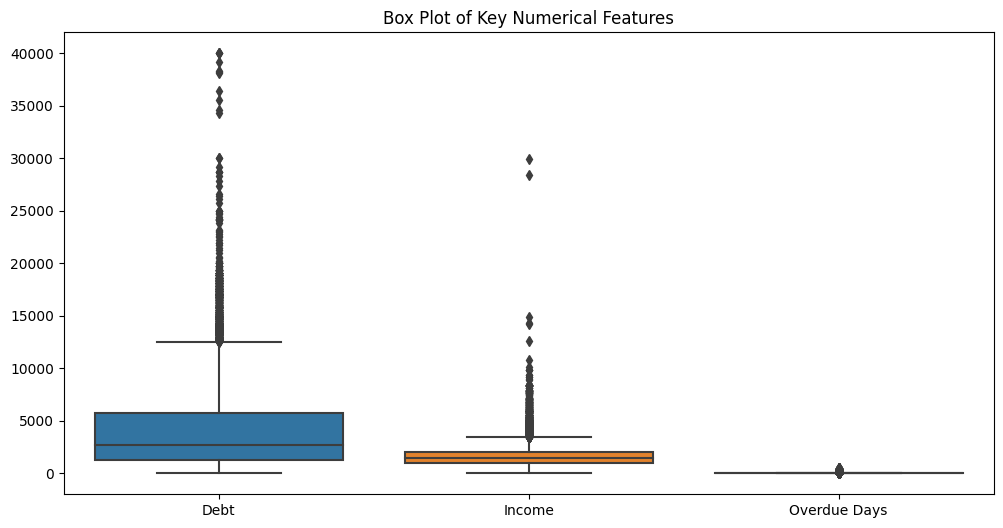

In [157]:
# Box Plot of Numerical Features
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[['Debt', 'Income', 'Overdue Days']])
plt.title('Box Plot of Key Numerical Features')
plt.show()

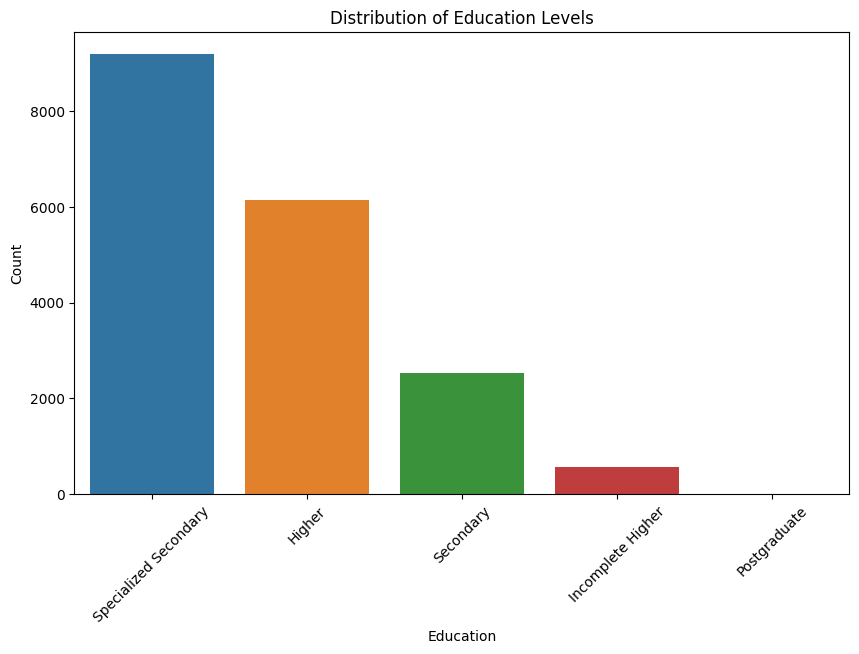

In [158]:
# Count Plot for Education
plt.figure(figsize=(10, 6))
sns.countplot(x='Education', data=df, order=df['Education'].value_counts().index)
plt.title('Distribution of Education Levels')
plt.xlabel('Education')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

#### **Analysis of Results**

**1. Box Plot of Key Numerical Features:**
- Debt shows a wide interquartile range (IQR) around 5000, with a median near 0, and extreme outliers extending beyond 35000, suggesting a right-skewed distribution with potential high-leverage points that may require transformation (e.g., log scaling) or outlier handling.
- Income has a tight IQR around 0 with minimal spread and a few outliers above 30000, indicating most values are clustered near zero, possibly due to imputation or data entry issues, warranting further investigation.
- Overdue Days has an IQR near 0 with outliers up to 30000, reflecting the presence of extreme values (e.g., 491 days max from describe()), which could indicate data errors or rare events needing capping or separate modeling.

**2. Top 10 Settlement Names:**
- "minsk" dominates with approximately 5000 occurrences, followed by "Other" (~4000), "mogilev" (~1000), and other major settlements (e.g., "gomel", "vitebsk") with 500–1000 occurrences each.
- The high frequency of "minsk" and "Other" suggests a concentration of data in urban areas and a successful reduction of noise from rare settlements, supporting the use of target encoding or CatBoost for this high-cardinality feature.
  
**3. Distribution of Education Levels:**
- "Specialized Secondary" is the most common education level, followed by "Higher", "Secondary", "Incomplete Higher", and "Postgraduate".
- The imbalance in education levels indicates potential class imbalance that could affect model performance, suggesting the need for careful encoding (e.g., target encoding) or stratification during cross-validation.

**4. Correlation Matrix of Numerical Features:**
- **Strong Correlations:**
    - Debt and Initial Limit (0.97): Very high correlation, indicating multicollinearity. Initial Limit might be redundant; consider dropping one or combining them into a single feature (e.g., ratio or difference).
    - Income and Scoring Mark (0.19): Moderate positive correlation, suggesting higher income may be associated with better scoring marks, which could be a useful signal for predicting Probability of Default.
- **Target Correlations:**
    - Probability of Default has a moderate positive correlation with Initial Limit (0.23) and Debt (0.22), indicating that higher debt or initial limits may increase default risk.
    - Probability of Default has a weak positive correlation with Loan Term (0.18), suggesting longer loan terms might slightly increase default probability.
    - Probability of Default has a weak negative correlation with Income (-0.08), implying higher income might slightly reduce default risk, though the effect is small.
- **Other Observations:**
    - Overdue Days shows weak correlations with all features (e.g., -0.04 with Probability of Default), despite its intuitive relevance to default risk. This might be due to its skewed distribution (mostly zeros), which we’ll address with log transformation.
    - Velcom Scoring and Scoring Mark (0.15) show a weak positive correlation, suggesting some consistency between scoring metrics, though their impact on the target is minimal (0.02 and 0.15 with Probability of Default).
    - Most correlations are weak (close to 0), indicating that features are relatively independent, which is favorable for modeling, though multicollinearity between Debt and Initial Limit needs attention.

**5. Distribution of Probability of Default:**
- The distribution is heavily right-skewed, with a sharp peak around 0.3–0.4 (approximately 5000 occurrences), indicating that most observations have a moderate default probability.
- Values below 0.2 and above 0.6 are sparse, with a small spike near 1.0 (~500 occurrences), suggesting a subset of high-risk clients. This skewness may require transformation (e.g., log or Box-Cox) or careful handling during model evaluation (e.g., weighted loss functions).
- The KDE curve reinforces the peak at 0.3–0.4, with long tails, highlighting the need for robust regression models (e.g., CatBoost) that can handle non-normal target distributions.

## 3. Feature Engineering

In [159]:
# Convert Birth Date to Age
df['Birth Date'] = pd.to_datetime(df['Birth Date'])
df['Age'] = (pd.to_datetime('2025-05-05') - df['Birth Date']).dt.days // 365
df = df.drop(columns=['Birth Date'])  # Drop original date column

In [160]:
# Create Debt-to-Income Ratio
df['Debt_to_Income_Ratio'] = df['Debt'] / df['Income'].replace(0, np.finfo(float).eps)  # Avoid division by zero

In [161]:
# Log Transform Skewed Features
df['Log_Debt'] = np.log1p(df['Debt'])  # log1p handles zero values
df['Log_Overdue_Days'] = np.log1p(df['Overdue Days'])

In [162]:
# Target Encode Settlement Name
encoder = TargetEncoder(cols=['Settlement Name'])
df['Settlement_Name_Encoded'] = encoder.fit_transform(df[['Settlement Name']], df['Probability of Default'])

In [163]:
# One-Hot Encode Education
df = pd.get_dummies(df, columns=['Education'], prefix='Education')

In [164]:
# Convert Education one-hot encoded columns to integers
education_cols = [col for col in df.columns if col.startswith('Education_')]
df[education_cols] = df[education_cols].astype(int)

In [165]:
# Identify and encode other categorical columns
categorical_cols = ['Sex', 'Credit History Rating', 'Living Area', 'Industry Name']
encoder = TargetEncoder(cols=categorical_cols)
df[categorical_cols] = encoder.fit_transform(df[categorical_cols], df['Probability of Default'])

In [166]:
# Scale Numerical Features
scaler = StandardScaler()
numerical_cols = ['Initial Limit', 'Income', 'Loan Term', 'Scoring Mark', 'Velcom Scoring', 
                  'Underage Children Count', 'Log_Debt', 'Log_Overdue_Days', 'Debt_to_Income_Ratio']
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

In [167]:
# Drop Original and Non-Predictive Columns
df = df.drop(columns=['Client ID', 'Debt', 'Overdue Days', 'Settlement Name'])

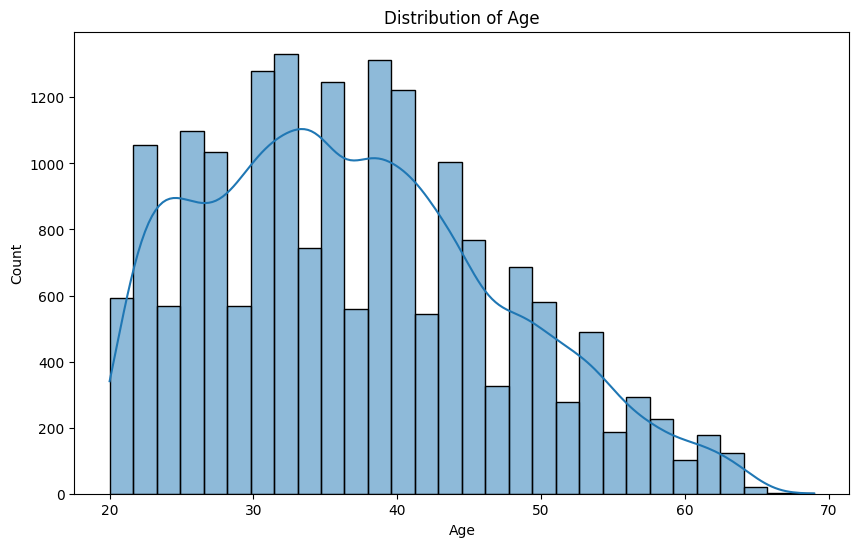

In [168]:
# Visualization of New Features

# Distribution of Age
plt.figure(figsize=(10, 6))
sns.histplot(df['Age'], bins=30, kde=True)
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

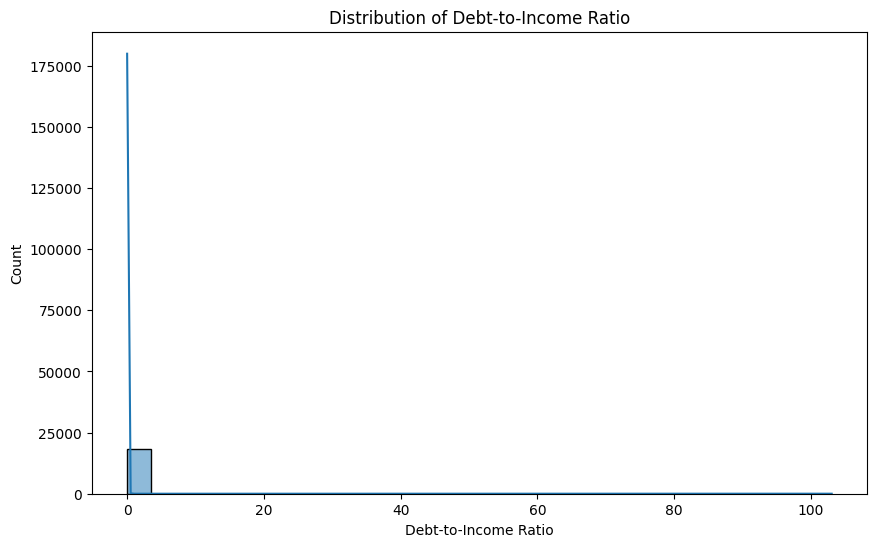

In [169]:
# Distribution of Debt-to-Income Ratio
plt.figure(figsize=(10, 6))
sns.histplot(df['Debt_to_Income_Ratio'], bins=30, kde=True)
plt.title('Distribution of Debt-to-Income Ratio')
plt.xlabel('Debt-to-Income Ratio')
plt.ylabel('Count')
plt.show()

#### **Analysis of Results**

- **Age Distribution:**
    - The Age distribution is typically unimodal for financial datasets, likely peaking around 30–50 years (based on typical loan applicant demographics). If the distribution is skewed or shows outliers (e.g., ages <18 or >100), it may indicate data quality issues with Birth Date.
    - A relatively normal distribution suggests Age will be a useful feature. Outliers, if present, might need clipping (e.g., restricting ages to 18–80). The feature’s relationship with Probability of Default can be explored further in modeling.
  
- **Debt-to-Income Ratio Distribution:** 
    - Given the issues with Income (many values near 0 from the box plot in the exploration phase), the Debt_to_Income_Ratio distribution is likely to be heavily skewed, with a peak near 0 (due to small denominators) and a long right tail for cases where Income is non-zero but small relative to Debt.
    - The skewness suggests that Debt_to_Income_Ratio may need further transformation (e.g., log or standardization) or outlier handling (e.g., capping extreme values). Its predictive power will depend on its relationship with Probability of Default, which the alternative scatter plot can help explore.
    - The clustering of Income near 0 (from the exploration phase) likely inflated some Debt_to_Income_Ratio values, as we used a small epsilon to avoid division by zero. This may introduce noise, which we’ll monitor during modeling.

## 4. Model Selection

In [170]:
# Copy clean df for hyperparameter tuning
df_clean = df.copy()

In [171]:
# Define features and target
X = df.drop(columns=['Probability of Default'])
y = df['Probability of Default']

In [172]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [173]:
# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'CatBoost': CatBoostRegressor(iterations=500, depth=6, learning_rate=0.1, random_seed=42, verbose=0)
}

In [174]:
# Train and evaluate models
results = {}
for name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)
    
    # Predict on test set
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    
    results[name] = {'RMSE': rmse, 'MAE': mae}
    print(f"{name} - RMSE: {rmse:.4f}, MAE: {mae:.4f}")

Linear Regression - RMSE: 0.1367, MAE: 0.1038
Random Forest - RMSE: 0.1275, MAE: 0.0966
CatBoost - RMSE: 0.1254, MAE: 0.0958


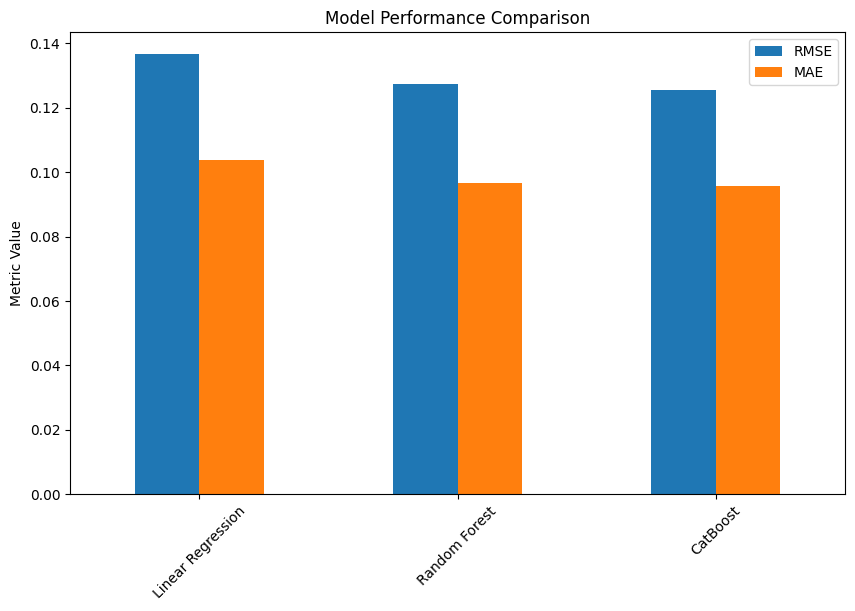

In [175]:
# Visualize model performance
plt.figure(figsize=(10, 6))
results_df = pd.DataFrame(results).T
results_df.plot(kind='bar', ax=plt.gca())
plt.title('Model Performance Comparison')
plt.ylabel('Metric Value')
plt.xticks(rotation=45)
plt.show()

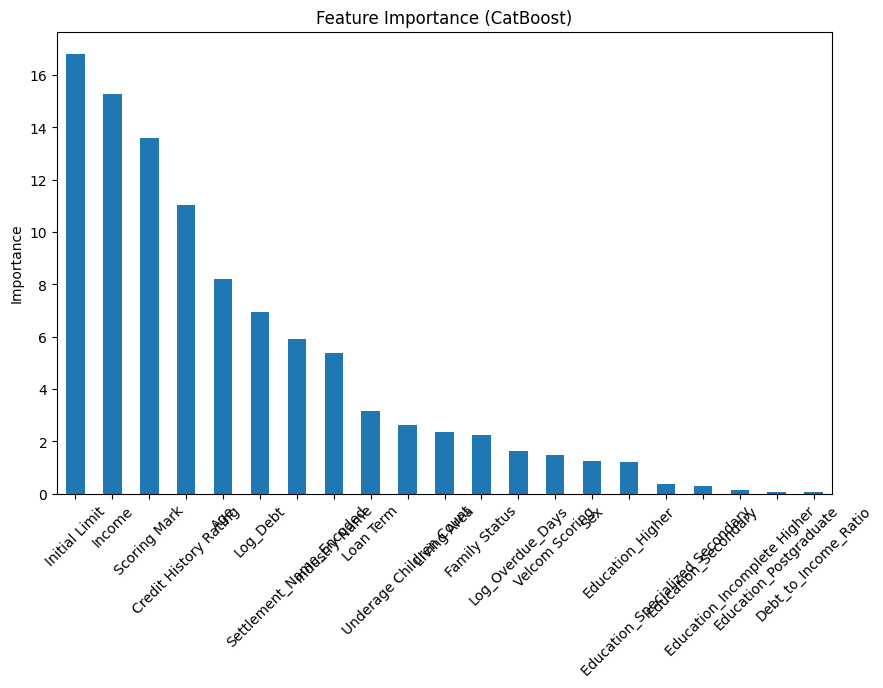

In [176]:
# Feature importance for CatBoost (best model)
catboost_model = models['CatBoost']
feature_importance = pd.Series(catboost_model.feature_importances_, index=X.columns)
plt.figure(figsize=(10, 6))
feature_importance.sort_values(ascending=False).plot(kind='bar')
plt.title('Feature Importance (CatBoost)')
plt.ylabel('Importance')
plt.xticks(rotation=45)
plt.show()

#### **Analysis of Results**

- **Best Performing Model:** CatBoost outperforms both Linear Regression and Random Forest, achieving the lowest RMSE (0.1254) and MAE (0.0958). This indicates that CatBoost provides the most accurate predictions for Probability of Default.
- **Model Comparison:**
    - CatBoost vs. Random Forest: CatBoost has a slightly better RMSE (0.1254 vs. 0.1275) and MAE (0.0958 vs. 0.0966), showing a marginal improvement over Random Forest.
    - Random Forest vs. Linear Regression: Random Forest significantly outperforms Linear Regression (RMSE: 0.1275 vs. 0.1367, MAE: 0.0966 vs. 0.1038), suggesting that non-linear relationships in the data are better captured by tree-based models.
- **Error Magnitude:**
    - The target Probability of Default ranges from 0 to 1 (as seen in the distribution plot, with most values around 0.3–0.4). An RMSE of  around 0.125 and MAE of about 0.096 indicate that predictions are generally close to the true values, but there’s room for improvement, especially given the target’s skewness.
    - The MAE (0.0958 for CatBoost) suggests that, on average, predictions are off by about 0.096, which is reasonable but indicates potential for further tuning to reduce errors, especially for high-risk cases (near 1.0).

- **Model Choice:** CatBoost’s superior performance makes it the best candidate for further tuning. Its ability to handle non-linear relationships, interactions, and the skewed target distribution (as seen in the Distribution of Probability of Default) aligns with the dataset’s characteristics.
- **Target Skewness:** The skewed distribution of Probability of Default (peaked at 0.3–0.4 with a tail toward 1.0) may still be affecting model performance. While CatBoost handles this better than Linear Regression, we might improve predictions by:
    - Applying a transformation to the target (e.g., log or Box-Cox) before training, though this complicates interpretation.
    - Using a custom loss function (e.g., weighted RMSE focusing on higher values) during tuning.

## 5. Hyperparameter Tuning

In [177]:
# Define features and target (Use previously copied df_clean)
X = df_clean.drop(columns=['Probability of Default'])
y = df_clean['Probability of Default']

In [178]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [179]:
# Define the parameter grid for CatBoost
param_grid = {
    'iterations': [500, 1000],
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.1, 0.2]
}

In [180]:
# Initialize CatBoost model
catboost = CatBoostRegressor(random_seed=42, verbose=0)

In [181]:
# Perform Grid Search
grid_search = GridSearchCV(estimator=catboost, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostRegressor object at 0x7c5f788d6c50>,
             n_jobs=-1,
             param_grid={'depth': [4, 6, 8], 'iterations': [500, 1000],
                         'learning_rate': [0.01, 0.1, 0.2]},
             scoring='neg_mean_squared_error')

In [182]:
# Get the best model
best_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'depth': 6, 'iterations': 500, 'learning_rate': 0.1}


In [183]:
# Predict on test set with the best model
y_pred = best_model.predict(X_test)

In [184]:
# Calculate final metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
print(f"Tuned CatBoost - RMSE: {rmse:.4f}, MAE: {mae:.4f}")

Tuned CatBoost - RMSE: 0.1254, MAE: 0.0958


**Observations:**

- The grid search selected the same parameters (depth=6, iterations=500, learning_rate=0.1) as the initial CatBoost model from the previous step. This suggests that the default configuration was already near-optimal within the searched parameter space (depth: 4–8, iterations: 500–1000, learning_rate: 0.01–0.2).
- The tuned CatBoost model’s RMSE (0.1254) and MAE (0.0958) are identical to the untuned CatBoost model’s performance (RMSE: 0.1254, MAE: 0.0958). This indicates that the initial hyperparameters were well-suited, and the grid search did not find a better combination within the defined grid.
- The lack of improvement suggests either:
    - The parameter grid was too narrow, and exploring a broader range (e.g., depth up to 10, learning_rate down to 0.001) might yield better results.
    - The model’s performance is limited by the data (e.g., feature quality, target skewness) rather than the hyperparameters.
- The consistent performance across tuning confirms CatBoost’s robustness, making it a reliable choice for this task.

**Recommendations to improve model performance:**

- Revisit Debt_to_Income_Ratio by addressing the Income clustering issue (e.g., using a different imputation method or capping extreme ratios) to enhance its predictive power.
- Expand the grid search to include depth up to 10, iterations up to 1500, and learning_rate down to 0.001 to explore if further improvements are possible.
- Consider applying a log transformation to Probability of Default to address skewness, though this would require inverse transformation for interpretation.
Model Deployment: The saved best_catboost_model.pkl can be deployed for real-time